# **Exploratory data analysis**

EDA represents various fixture-level college basketball (NCAA Basketball / which is added to the database (mydatabase.db)) statistics from the past 2 years. The objective is to build a model that is able to predict the winners for the upcoming fixtures.
The Raw data contains > FixtureKey,Team,X2PM,X2PA,X3PM,X3PA,FTM,FTA,ORB,DRB,AST,STL,BLK,TOV,PF 

The EDA itself is an exploratory section in the project, hence the simplistic regression model is adopted in the process. Not much effort is taken into evaluate the model or calibrate the model as the focus of the assessment is something else. The winner prediction model here extremely confident in its predictions, this can be due to overfitting or certain features heavily influencing the model's decision boundary. One of the main reason is the base score calcutaion itself is based on the variables that have low confidence. 

## Data preparation
Please refer to section 2.a, titled 'Data preprocessing,' in the README.MD for the code related to transferring data into the database

## Data Preprocessing
Please refer to section 2.b in the README.MD for the code where extensive data cleaning is performed using SQL queries instead of Python. In Python, we solely rely on SQL queries to retrieve the already cleaned data.

### Libraries/Main Query 
Performing extensive data cleaning within SQL queries focuses on data preprocessing. Specifically, it addresses the task of making the initial calculations to obtain the necessary variables to cacluate the base score of each team within the fixture.


In [21]:
#Libraries
import sqlite3
import pandas as pd
import os
import matplotlib
import datetime
import calendar

In [8]:
con = sqlite3.connect('mydatabase.db')  #conneting to database 
df_box_score_query = """
WITH TeamAvTeamB AS (
    SELECT
        bs.FixtureKey,
        SUBSTR(bs.FixtureKey, 1, LENGTH(bs.FixtureKey) - 12) AS TeamAvTeamB
    FROM
        box_scores AS bs
)

-- Query 1 as a CTE
, Query1 AS (
    SELECT DISTINCT
        TRIM(CASE
                WHEN bs.Team = 1 THEN SUBSTR(TeamAvTeamB, 1, INSTR(TeamAvTeamB, 'v') - 1)
                WHEN bs.Team = 2 THEN SUBSTR(TeamAvTeamB, INSTR(TeamAvTeamB, 'v') + 1)
                ELSE NULL
            END) AS TeamName,  
        AVG(bs.ORB) AS ORBAvg,
        AVG(bs.DRB) AS DRBAvg,
        AVG(bs.STL) AS STLAvg,
        AVG(bs.BLK) AS BLKAvg,
        AVG(bs.PF) AS PFAvg
        
    FROM
        TeamAvTeamB AS ta
    JOIN box_scores AS bs ON ta.FixtureKey = bs.FixtureKey
    GROUP BY
        TeamName
)

-- Query 2 as a CTE
, Query2 AS (
    SELECT
        bs.FixtureKey,
        TRIM(CASE
                WHEN bs.Team = 1 THEN SUBSTR(TeamAvTeamB, 1, INSTR(TeamAvTeamB, 'v') - 1)
                WHEN bs.Team = 2 THEN SUBSTR(TeamAvTeamB, INSTR(TeamAvTeamB, 'v') + 1)
                ELSE NULL
            END) AS TeamName,
        TRIM(CASE
                WHEN bs.Team = 2 THEN SUBSTR(TeamAvTeamB, 1, INSTR(TeamAvTeamB, 'v') - 1)
                WHEN bs.Team = 1 THEN SUBSTR(TeamAvTeamB, INSTR(TeamAvTeamB, 'v') + 1)
                ELSE NULL
            END) AS Oppnent,
            CASE
              WHEN bs.Team = 1 THEN 'Yes'
              WHEN bs.TeaM = 2 THEN 'No'
              ELSE NULL
              END AS HomeTeamAdv,
        bs.Team, bs.X2PM, bs.X2PA, bs.X3PM, bs.X3PA, bs.FTM, bs.FTA, bs.ORB, bs.DRB, bs.AST, bs.STL, bs.BLK, bs.TOV,
        bs.PF,
        ROUND((CAST(bs.X2PM AS REAL) + CAST(bs.X3PM AS REAL)) / (CAST(bs.X2PA AS REAL) + CAST(bs.X3PA AS REAL))*100,2) AS 'FG%',
        ROUND((CAST(bs.X2PM AS REAL) / CAST(bs.X3PA AS REAL))*100,2)  AS '3P%',
        ROUND((CAST(bs.FTM AS REAL) / CAST(bs.FTA AS REAL))*100,2)  AS 'FT%',
        ROUND((CAST(bs.AST AS REAL) / CAST(bs.TOV AS REAL))*100,2)  AS 'ASTtoTOV%'
    FROM
        TeamAvTeamB AS ta
    JOIN box_scores AS bs ON ta.FixtureKey = bs.FixtureKey
)

-- CTE3  Query joining Query1 and Query2 using TeamName
, FinalCTE AS (SELECT DISTINCT
    Query2.FixtureKey, Query2.TeamName,Query2.Oppnent, Query2.HomeTeamAdv, Query2.Team,Query2.X2PM, Query2.X2PA, Query2.X3PM, Query2.X3PA,Query2.FTM, Query2.FTA,
    Query2.ORB,Query2.DRB,Query2.AST,Query2.STL,Query2.BLK,Query2.TOV, Query2.PF,Query2.'FG%', Query2.'3P%',Query2.'FT%',Query2.'ASTtoTOV%',
    ROUND(Query1.ORBAvg, 2) AS ORBAvg,
    ROUND(Query3.ORBAvg, 2 ) AS OppORBAvg,
    ROUND(Query1.DRBAvg, 2) AS DRBAvg,
    ROUND(Query3.DRBAvg, 2) AS OppDRBAvg,
    ROUND(Query1.STLAvg, 2) AS STLAvg,
    ROUND(Query1.BLKAvg, 2) AS BLKAvg,
    ROUND(Query1.PFAvg, 2) AS PFAvg,
    ROUND(Query3.PFAvg, 2) AS OppPFAvg
    
FROM
    Query1
JOIN Query2 ON Query1.TeamName = Query2.TeamName
JOIN Query1 AS Query3 ON Query2.Oppnent = Query3.TeamName

)

--Joining Final CTE from BOX score table with fixture_information

 SELECT FinalCTE.FixtureKey, FinalCTE.TeamName ,FinalCTE.Oppnent, FinalCTE.'FG%',FinalCTE.'3P%',
 FinalCTE.'FT%', FinalCTE.'ASTtoTOV%',
 (FinalCTE.ORBAvg-FinalCTE.OppORBAvg) AS ORD,
 (FinalCTE.DRBAvg-FinalCTE.OppDRBAvg) AS DRD,
 FinalCTE.STLAvg ,FinalCTE.BLKAvg,
 (FinalCTE.PFAvg-FinalCTE.OppPFAvg) AS DiffPFAvg, 
 FinalCTE.HomeTeamAdv,
 fixture_information.TipOff AS TipOff,             
 fixture_information.GameType AS GameType, 
 fixture_information.IsNeutralSite AS IsNeutralSite,
 fixture_information.Attendance AS Attendance,
 fixture_information.Season AS Season,
 fixture_information.Team1Conference AS Team1Conference,
 fixture_information.Team2Conference AS Team2Conference
 FROM
     FinalCTE
 JOIN fixture_information ON FinalCTE.FixtureKey = fixture_information.FixtureKey"""

In [5]:


df_box_scores = pd.read_sql_query(df_box_score_query, con)
df = pd.read_sql_query(df_query,con)
def avgscore(dataframe,dataframe2,team,newcol1,newcol2,func):
    for n in dataframe[team]:
        if n == 1:
            dataframe['2PM(H)'] = dataframe['X2PM'].groupby(dataframe['HomeTeam']).transform(func)
            dataframe['3PM(H)'] = dataframe['X3PM'].groupby(dataframe['HomeTeam']).transform(func)
            dataframe['FTM(H)'] = dataframe['FTM'].groupby(dataframe['HomeTeam']).transform(func)
            dataframe2[newcol1] = (dataframe['2PM(H)'])*2 + (dataframe['3PM(H)'])*3 + dataframe['FTM(H)']
        else:
            dataframe['2PM(A)'] = dataframe['X2PM'].groupby(dataframe['AwayTeam']).transform(func)
            dataframe['3PM(A)'] = dataframe['X3PM'].groupby(dataframe['AwayTeam']).transform(func)
            dataframe['FTM(A)'] = dataframe['FTM'].groupby(dataframe['AwayTeam']).transform(func)
            dataframe2[newcol2] = (dataframe['2PM(A)'])*2 + (dataframe['3PM(A)'])*3 + dataframe['FTM(A)']
    
    return dataframe

df_box_scores = avgscore(df,df_box_scores_2,'Team','AvgPts(H)','AvgPts(A)','mean')
df_box_scores

,FixtureKey,TeamName,Oppnent,FG%,3P%,FT%,ASTtoTOV%,ORD,DRD,STLAvg,BLKAvg,DiffPFAvg,HomeTeamAdv
0,LIPSCO v A PEAY 14-Jan-2023,LIPSCO,A PEAY,50.98,72.73,82.76,130.77,-2.38,5.55,4.82,2.47,-4.13,Yes
1,LIPSCO v A PEAY 14-Jan-2023,A PEAY,LIPSCO,40.32,85.71,93.75,108.33,2.38,-5.55,6.11,2.60,4.13,No
2,QUENNC v A PEAY 29-Dec-2022,QUENNC,A PEAY,49.02,94.74,66.67,107.69,0.01,2.71,5.65,2.45,-0.14,Yes
3,QUENNC v A PEAY 29-Dec-2022,A PEAY,QUENNC,45.16,111.11,86.67,180.00,-0.01,-2.71,6.11,2.60,0.14,No
4,FGCU v A PEAY 24-Feb-2023,FGCU,A PEAY,51.72,65.38,80.00,166.67,-0.64,3.74,6.15,4.20,-2.14,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13317,YSU v SIUE 20-Nov-2021,SIUE,YSU,47.92,73.68,63.64,82.35,0.73,0.51,6.65,3.65,1.29,No
13318,YSU v OAK 09-Feb-2022,YSU,OAK,44.12,63.64,81.82,222.22,1.02,1.43,6.68,2.53,3.23,Yes
13319,YSU v OAK 09-Feb-2022,OAK,YSU,41.82,78.26,80.00,92.86,-1.02,-1.43,8.54,2.44,-3.23,No
13320,DET v YSU 12-Jan-2023,DET,YSU,47.76,113.04,75.00,240.00,0.50,-1.10,6.03,1.69,-1.68,Yes


In [ ]:
def findDay(date):
    born = datetime.datetime.strptime(date, '%d-%b-%Y').weekday()
    return (calendar.day_name[born])

In [7]:
con.close()  #close the connnection

In [2]:
#Code here

Alternative work

In [3]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
df_box_score = pd.read_sql_query(df_box_score_query, con)
df_box_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13322 entries, 0 to 13321
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   FixtureKey       13322 non-null  object 
 1   TeamName         13322 non-null  object 
 2   Oppnent          13322 non-null  object 
 3   FG%              13322 non-null  float64
 4   3P%              13322 non-null  float64
 5   FT%              13320 non-null  float64
 6   ASTtoTOV%        13322 non-null  float64
 7   ORD              13322 non-null  float64
 8   DRD              13322 non-null  float64
 9   STLAvg           13322 non-null  float64
 10  BLKAvg           13322 non-null  float64
 11  DiffPFAvg        13322 non-null  float64
 12  HomeTeamAdv      13322 non-null  object 
 13  TipOff           13322 non-null  object 
 14  GameType         13322 non-null  object 
 15  IsNeutralSite    13322 non-null  int64  
 16  Attendance       13322 non-null  int64  
 17  Season      

In [4]:
%matplotlib inline

### Data Preprocessing (dplyr)
Further the table is cleaned using dplyr. Task of splitting the columns in the data obtained from the initial data preparation is done here, which are initially in the format TeamA_v_TeamB Date' into separate team names. This separation allows for more efficient and structured analysis of each team's aggregate statistics

In [10]:
def fiter_box_scoreFun(df: pd.DataFrame) -> pd.DataFrame:
    # Extracting Date and Day
    df['Date'] = df['FixtureKey'].str.split(" ").apply(lambda x: x[-1])
    df['Day'] = pd.to_datetime(df['Date'], format='%d-%b-%Y').dt.day_name()
    df = df.drop('Date', axis='columns')
    
    # HomeTeamAdv Manipulation
    conditions = [
        (df['HomeTeamAdv'] == "Yes") & (df['IsNeutralSite'] == 0),
        (df['HomeTeamAdv'] == "No") & (df['IsNeutralSite'] == 1),
        (df['HomeTeamAdv'] == "Yes") & (df['IsNeutralSite'] == 1),
    ]
    choices = ['Yes', 'No', 'No']
    df['HomeTeamAdv'] = pd.np.select(conditions, choices, default='No')
    df = df.drop('IsNeutralSite', axis=1)
    df['HomeTeamAdv'] = df['HomeTeamAdv'].apply(lambda x: 0.05 if x == "Yes" else 0)
    
    # Base_score Calculation
    df['Base_score'] = (df['FG%']*0.3 + df['3P%']*0.2 + df['FT%']*0.1 + df['ASTtoTOV%']*0.2 + df['ORD']*0.05 + 
                        df['DRD']*0.05 + df['STLAvg']*0.03 + df['BLKAvg']*0.02 + df['DiffPFAvg']*0.03 + 
                        df['HomeTeamAdv'])
    
    # GameType factor
    game_type_conditions = [
        df["GameType"] == "RegularSeason",
        df["GameType"] == "ConferenceChampionship",
        df["GameType"] == "NIT"
    ]
    game_type_choices = [
        df['Base_score']*1,
        df['Base_score']*1.1,
        df['Base_score']*1.2
    ]
    df['Base_score'] = pd.np.select(game_type_conditions, game_type_choices, default=df['Base_score']*1)
    
    # Time_multiplier and its factor
    df['Time_multiplier'] = df['TipOff'].str.split(":").apply(lambda x: x[0]).astype(int)
    time_conditions = [
        (df["Time_multiplier"] >=6) & (df["Time_multiplier"] < 12),
        (df["Time_multiplier"] >=12) & (df["Time_multiplier"] < 17),
        (df["Time_multiplier"] >=17) & (df["Time_multiplier"] < 21)
    ]
    time_choices = [
        df['Base_score']*0.98,
        df['Base_score']*1,
        df['Base_score']*1.02
    ]
    df['Base_score'] = pd.np.select(time_conditions, time_choices, default=df['Base_score']*1.01)
    
    # Day factor
    day_conditions = [
        df["Day"] == day for day in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    ]
    day_choices = [
        df['Base_score']*1,
        df['Base_score']*1,
        df['Base_score']*1,
        df['Base_score']*1,
        df['Base_score']*1.01,
        df['Base_score']*1.02,
        df['Base_score']*1.01
    ]
    df['Base_score'] = pd.np.select(day_conditions, day_choices, default=df['Base_score']*1)
    
    # Attendance factor
    max_attendance = df['Attendance'].max()
    df['Base_score'] = df.apply(lambda row: row['Base_score'] if row['Attendance'] == 0 else 
                                row['Base_score'] + 0.05 * (row['Attendance'] / max_attendance), axis=1)
    
    return df[['FixtureKey', 'TeamName', 'Oppnent', 'Base_score']]



In [15]:
warnings.filterwarnings('ignore')
dfBoxScore = fiter_box_scoreFun(df_box_score)
v

,FixtureKey,TeamName,Oppnent,Base_score
0,LIPSCO v A PEAY 14-Jan-2023,A PEAY,LIPSCO,62.923080
1,LIPSCO v A PEAY 14-Jan-2023,LIPSCO,A PEAY,67.156363
2,QUENNC v A PEAY 29-Dec-2022,A PEAY,QUENNC,82.151708
3,QUENNC v A PEAY 29-Dec-2022,QUENNC,A PEAY,63.504884
4,FGCU v A PEAY 24-Feb-2023,A PEAY,FGCU,72.299541
...,...,...,...,...
13317,YSU v SIUE 20-Nov-2021,YSU,SIUE,53.320729
13318,YSU v OAK 09-Feb-2022,OAK,YSU,55.953850
13319,YSU v OAK 09-Feb-2022,YSU,OAK,80.693746
13320,DET v YSU 12-Jan-2023,DET,YSU,94.473666


In [16]:
warnings.filterwarnings('ignore')
dfBoxScoresHome = fiter_box_scoreFun(df_box_score[df_box_score['HomeTeamAdv']=="Yes"])
dfBoxScoresHome

,FixtureKey,TeamName,Oppnent,Base_score
1,LIPSCO v A PEAY 14-Jan-2023,LIPSCO,A PEAY,67.156363
3,QUENNC v A PEAY 29-Dec-2022,QUENNC,A PEAY,63.504884
5,FGCU v A PEAY 24-Feb-2023,FGCU,A PEAY,72.461076
6,A PEAY v NO FLA 18-Feb-2023,A PEAY,NO FLA,83.014326
8,A PEAY v JVILLE 16-Feb-2023,A PEAY,JVILLE,39.893686
...,...,...,...,...
13312,GRNBAY v YSU 19-Jan-2023,GRNBAY,YSU,54.798674
13315,YSU v NIAGRA 21-Nov-2021,YSU,NIAGRA,43.554265
13317,YSU v SIUE 20-Nov-2021,YSU,SIUE,53.320729
13319,YSU v OAK 09-Feb-2022,YSU,OAK,80.693746


In [18]:
warnings.filterwarnings('ignore')
dfBoxScoresAway = fiter_box_scoreFun(df_box_score[df_box_score['HomeTeamAdv']=="No"])
dfBoxScoresAway

,FixtureKey,TeamName,Oppnent,Base_score
0,LIPSCO v A PEAY 14-Jan-2023,A PEAY,LIPSCO,62.923080
2,QUENNC v A PEAY 29-Dec-2022,A PEAY,QUENNC,82.151708
4,FGCU v A PEAY 24-Feb-2023,A PEAY,FGCU,72.299541
7,A PEAY v NO FLA 18-Feb-2023,NO FLA,A PEAY,43.276452
9,A PEAY v JVILLE 16-Feb-2023,JVILLE,A PEAY,58.834066
...,...,...,...,...
13313,GRNBAY v YSU 19-Jan-2023,YSU,GRNBAY,81.901196
13314,YSU v NIAGRA 21-Nov-2021,NIAGRA,YSU,49.272885
13316,YSU v SIUE 20-Nov-2021,SIUE,YSU,53.366527
13318,YSU v OAK 09-Feb-2022,OAK,YSU,55.953850


## Winner Prediction model
A separate winner prediction model is created here.

<Axes: >

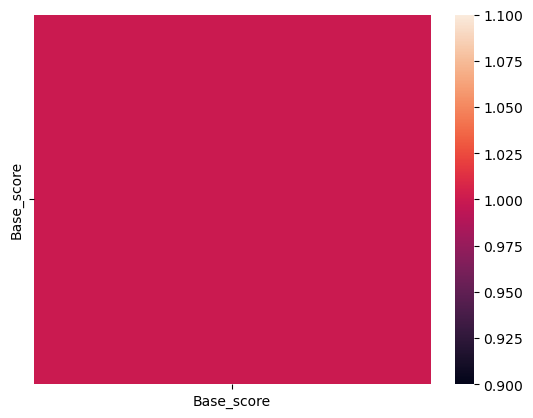

In [27]:
sns.heatmap(dfBoxScore.corr())


####Acronyms</br>
X2PM = 2 pointer made, X2PA=2 pointer attemped, X3PM = 3 pointer made, X3PA = 2 pointer attempted,FTM = free throws made,
FTA = free throws attempted, ORB = offensive rebounds, DRB = deffensive rebounds, AST = assist, STL= steal, BLK = block, TOV = turnovers, PF = personal fouls
FG% = ratio of successful field goals (2PM + 3PM) to total field goal attempts (2PA + 3PA), </br>
3P% = ratio of successful three-pointers (3PM) to total three-point attempts (3PA),</br>
FT% = ratio of successful free throws (FTM) to total free throw attempts (FTA),</br>
ASTtoTOV%  = This ratio measures a team's ball-handling efficiency. It's the ratio of assists (AST) to turnovers (TOV). Assist-to-Turnover Ratio (AST/TOV),</br>
ORD = difference between the average offensive rebounds (ORB) a team secures and the average offensive rebounds their opponents secure,</br>
DRD =  the difference between the average defensive rebounds (DRB) a team secures and the average defensive rebounds their opponents secure,</br>
STLAvg = SteaL average of a team , BLKAvg = Block average of a team,</br>
DiffPFAvg = the average difference in the number of fouls committed (PF) between a team and its opponents,</br>
HomeTeamAdv = Home Court Advantage
